<a href="https://colab.research.google.com/github/M-Amrollahi/Personal-Notes/blob/master/ML-notes/mnist_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [324]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torchvision import datasets
from IPython.display import display
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn
import sklearn.metrics as metr
from sklearn.decomposition import PCA

In [280]:
dsmnist = datasets.MNIST("./",download=True)

In [337]:
X_train, X_test, y_train, y_test = train_test_split(dsmnist.data, dsmnist.targets,test_size=.1,stratify=dsmnist.targets)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=.05, stratify=y_test)

In [283]:
class cls_data(Dataset):
    
    def __init__(self, x, y):
        super().__init__()
        self.data = x
        self.target = y
    def __len__(self):
        return len(self.target)
    def __getitem__(self, index) :
        return self.data[index].unsqueeze(dim=0), self.target[index]


In [284]:
ds_train = cls_data(X_train/255., y_train)
ds_test = cls_data(X_test/255., y_test)
ds_val = cls_data(X_val/255.,y_val)

train_loader = DataLoader(ds_train,batch_size=16)
test_loader = DataLoader(ds_test,batch_size=16)
val_loader = DataLoader(ds_val,batch_size=16)

In [292]:
from collections import OrderedDict
class cls_model(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.model_feature = nn.Sequential(OrderedDict([
            ("conv1", nn.Conv2d(in_channels=1,out_channels=3,kernel_size=(3,3))),
            ("maxp1", nn.MaxPool2d(2,2))]))
        
        self.model_classify = nn.Sequential(OrderedDict([
            ("linear1",nn.Linear(13*13*3,500)),
            ("relu1",nn.ReLU()),
            ("layernorm1",nn.LayerNorm(500)),
            ("dropout1", nn.Dropout(p=.1)),
            ("linear2",nn.Linear(500,10))]
        ))
        #self.conv1 = torch.nn.Conv2d(in_channels=1,out_channels=3,kernel_size=(3,3))
        #self.maxp = torch.nn.MaxPool2d(2,2)
        #self.l1 = torch.nn.Linear(13*13*3,500)
        #self.lnorm1 = torch.nn.LayerNorm(500)
        #self.relu1 = torch.nn.ReLU()
        #self.drop1 = torch.nn.Dropout(p=.1)
        #self.l2 = torch.nn.Linear(500,10)

    def forward(self, x):
        #x = torch.permute(x,()
        #x = self.conv1(x)
        #x = self.maxp(x)
        x = self.model_feature.forward(x)

        x = x.reshape((x.shape[0],-1))
        
        y = self.model_classify(x)
        #y = self.l2.forward(self.drop1( self.lnorm1(self.relu1( self.l1.forward(x)))))

        return y

In [293]:
model = cls_model()
model
#model.forward(X_train[:5]/255.)

cls_model(
  (model_feature): Sequential(
    (conv1): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1))
    (maxp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (model_classify): Sequential(
    (linear1): Linear(in_features=507, out_features=500, bias=True)
    (relu1): ReLU()
    (layernorm1): LayerNorm((500,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=500, out_features=10, bias=True)
  )
)

In [294]:
def f_validate(model, dloader, criterion):
    model.eval()
    preds = torch.empty(0)
    targets = torch.empty(0)

    tmpLoss = 0
    for i , (x_batch, y_batch) in enumerate(dloader):
        y_pred = model.forward(x_batch)
        preds = torch.cat((preds, y_pred.argmax(dim=1)))
        targets = torch.cat((targets,y_batch))

        tmpLoss += criterion(y_pred, y_batch).item() / len(y_batch)
        #lst_pred.append( [y_pred.argmax(dim=1),y_batch])
    
    return targets.detach().numpy(), preds.detach().numpy() , tmpLoss

In [295]:
criterion = torch.nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr=1e-3)

epochs = 20

dict_res = dict()
for i in range(epochs):
    tmpLoss = 0.
    for j,(x_batch, y_batch) in enumerate(train_loader):

        y_pred = model.forward(x_batch)
        #print(y_pred.shape)
        #print(y_batch.unsqueeze(dim=1).shape)
        loss = criterion(y_pred, y_batch)

        optim.zero_grad()
        loss.backward()
        optim.step()

        tmpLoss += loss.item() / len(y_batch)

        #break
    print("Loss:" , tmpLoss)
    target , pred, valLoss = f_validate(model, val_loader, criterion)
    print("Val acc:", metr.accuracy_score(target,pred), "Val loss: ", valLoss)
    dict_res[i] = tmpLoss

Loss: 110.65624448587187
Val acc: 0.9175 Val loss:  1.4646462802775204
Loss: 51.29999950330239
Val acc: 0.93 Val loss:  1.0927996154641733
Loss: 38.61577428737655
Val acc: 0.9475 Val loss:  0.9042239282280207
Loss: 31.61503527330933
Val acc: 0.9541666666666667 Val loss:  0.7887071478180587
Loss: 26.974761889956426
Val acc: 0.9616666666666667 Val loss:  0.7117503937915899
Loss: 23.61499532670132
Val acc: 0.9641666666666666 Val loss:  0.6576144715072587
Loss: 21.02983559394488
Val acc: 0.9658333333333333 Val loss:  0.6160767178516835
Loss: 18.961756214790512
Val acc: 0.97 Val loss:  0.5854194757703226
Loss: 17.22585506385076
Val acc: 0.97 Val loss:  0.5584997901460156
Loss: 15.749924018135061
Val acc: 0.9716666666666667 Val loss:  0.5354654876864515
Loss: 14.475815278536174
Val acc: 0.9716666666666667 Val loss:  0.5175923689967021
Loss: 13.362895345155266
Val acc: 0.9716666666666667 Val loss:  0.5014420833904296
Loss: 12.37190948271018
Val acc: 0.9716666666666667 Val loss:  0.48782956230

In [298]:
target , pred, testLoss  = f_validate(model,test_loader,criterion)
metr.accuracy_score(target,pred)

0.9789583333333334

In [296]:
metr.accuracy_score(targets.detach().numpy(),preds.detach().numpy())*100

97.65

In [299]:
confusion = metr.confusion_matrix(targets.detach().numpy(),preds.detach().numpy())
confusion

array([[586,   0,   1,   0,   1,   1,   2,   0,   1,   0],
       [  0, 668,   2,   1,   3,   0,   0,   0,   0,   0],
       [  1,   1, 581,   3,   4,   0,   0,   4,   1,   1],
       [  0,   1,   8, 593,   0,   3,   0,   4,   2,   2],
       [  1,   0,   4,   1, 567,   0,   2,   2,   2,   5],
       [  2,   1,   0,   6,   0, 531,   1,   0,   1,   0],
       [  1,   0,   2,   0,   0,   3, 583,   0,   3,   0],
       [  1,   2,   6,   0,   1,   0,   1, 614,   0,   2],
       [  1,   3,   0,   7,   3,   4,   0,   1, 566,   0],
       [  3,   1,   1,   4,   4,   3,   0,   7,   2, 570]])

In [254]:
Image.fromarray(X_train[22].numpy())

In [303]:
a=model.model_feature.conv1.forward((X_train[22]/1.0).reshape((1,1,28,28)))

In [ ]:
Image.fromarray(a[0][0].detach().numpy()*255)

In [ ]:
torch.nn.functional.relu( a[0][2].detach().int()*255).numpy()


In [289]:
model.conv1.weight

Parameter containing:
tensor([[[[-0.0782, -0.2997, -0.3295],
          [-0.2342, -0.0104,  0.3223],
          [ 0.2272,  0.2727,  0.1785]]],


        [[[ 0.1371,  0.0940, -0.2440],
          [ 0.2977,  0.0737, -0.0637],
          [ 0.2613,  0.0803,  0.2684]]],


        [[[ 0.1564,  0.2556, -0.3126],
          [ 0.2258, -0.0264, -0.0728],
          [-0.0307,  0.0859,  0.0931]]]], requires_grad=True)

In [338]:
X_test.shape

torch.Size([300, 28, 28])

In [339]:
model_pca = PCA(2)


features = model.model_feature((X_test/255.0).reshape((300,1,28,28)))
feat2d = model_pca.fit_transform(features.reshape((300, -1)).detach().numpy())


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


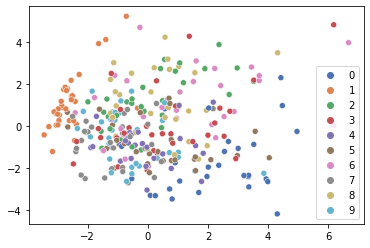

In [341]:
sns.scatterplot(feat2d[:,0], feat2d[:,1],hue=y_test,palette="deep")
#sns.scatterplot(feat2d[y_test==1][:,0], feat2d[y_test==1][:,1],marker=".")